In [1]:
# coding=utf-8
import sys
sys.path.append("D:\\HST\\QuantStudio")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2()

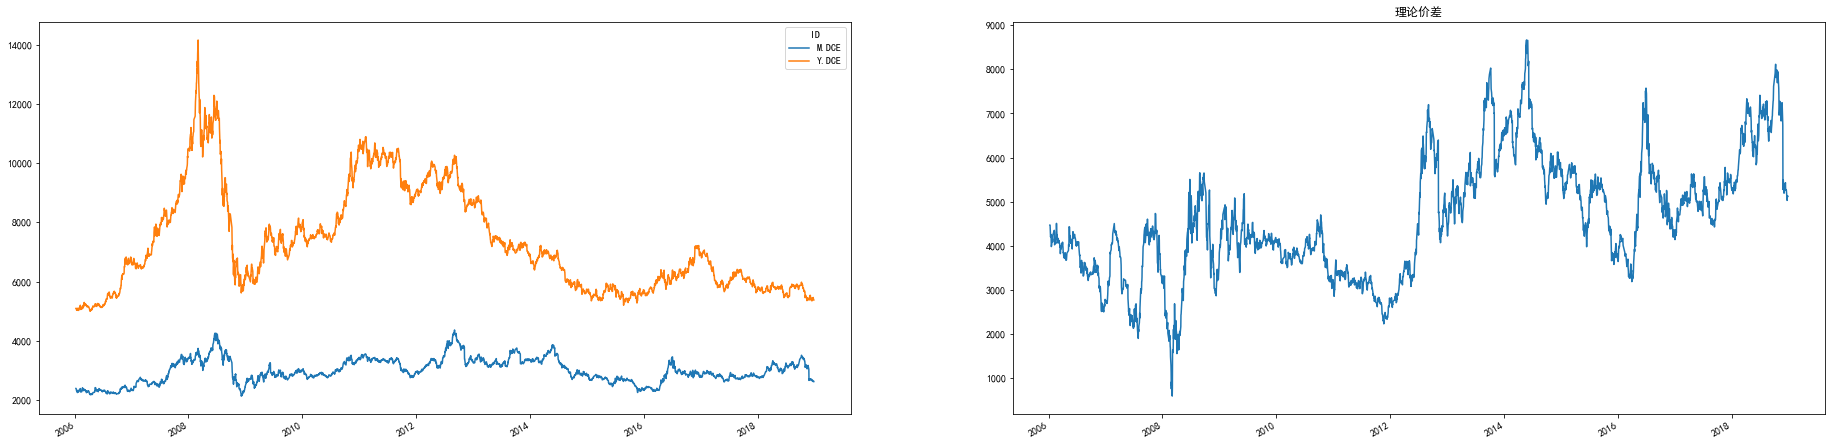

In [3]:
# 参数设置和数据准备
# IDs = ["M01.DCE", "Y01.DCE", "B01.DCE"]# 豆粕, 豆油连一合约
IDs = ["M.DCE", "Y.DCE"]# 豆粕, 豆油主力合约
TheoryHedgeRatio = np.array([4, -1])# 理论对冲比例
StartDT = dt.datetime(2006, 1, 9)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid="DCE", start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=IDs, dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
CCPrice = FT.readData(factor_names=[PriceFactor], ids=IDs, dts=DTs).iloc[0]
WDB.disconnect()

# 对连续合约的价格进行展期调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in FutureIDMap.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, FutureIDMap.columns]

# 理论价差
TheorySpread = (CCPrice * TheoryHedgeRatio).sum(axis=1)

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes[0])
TheorySpread.plot(kind="line", ax=Axes[1], title="理论价差");

In [4]:
# 价差的 ADF 检验
TheorySpreadADFTest = sm.tsa.stattools.adfuller(TheorySpread.values, regression='c', autolag="BIC")
print(("理论价差 ADF Test Statistic : %f" % TheorySpreadADFTest[0]), 
      ("pvalue : %f" % TheorySpreadADFTest[1]), 
      ("usedlag : %d" % TheorySpreadADFTest[2]), sep="\n")

理论价差 ADF Test Statistic : -2.919227
pvalue : 0.043157
usedlag : 0


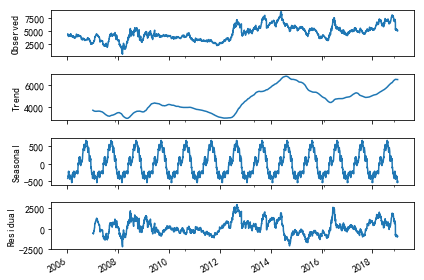

In [14]:
# 价差的趋势和周期分解
DecompositionResult = sm.tsa.seasonal_decompose(x=TheorySpread, model='additive', freq=240, two_sided=False)
DecompositionResult.plot();

HalfLife: 128.209102


,0
起始时点,2006-01-09 00:00:00
结束时点,2018-12-28 00:00:00
时点数,3159
总收益率,-0.188165
年化收益率,-0.0159373
年化波动率,0.061737
Sharpe比率,-0.258149
胜率,0.796455
最大回撤率,0.296543
最大回撤开始时点,2006-11-23 00:00:00


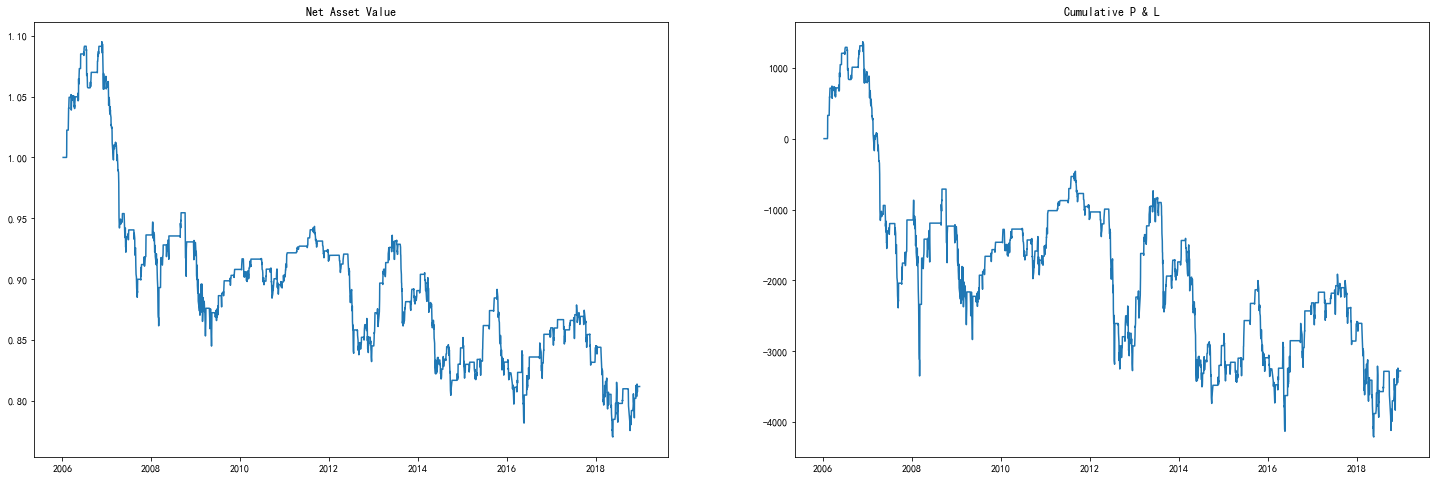

In [7]:
# --------Spread 策略--------
EntryThreshold, ExitThreshold = 2, 0
NumRatio = TheoryHedgeRatio
# NumRatio = HedgeRatio

# 生成信号
Spread = (CCPrice * NumRatio).sum(axis=1)
HalfLife = - np.log(2) / sm.OLS(np.diff(Spread.values), sm.add_constant(Spread.values[:-1], prepend=False)).fit().params[0]
print("HalfLife: %f" % HalfLife)
LookBack = 10
# LookBack = max(5, int(round(HalfLife)))
Zscore = (Spread - Spread.rolling(LookBack).mean()) / Spread.rolling(LookBack).cov()**0.5
NumUnits = np.full(shape=(CCPrice.shape[0], ), fill_value=np.nan)
# 空头信号
Mask = (Zscore.values>EntryThreshold)
NumUnits[Mask] = -1
# 多头信号
Mask = (Zscore.values<-EntryThreshold)
NumUnits[Mask] = 1
# 平仓信号
PreNumUnits = pd.Series(NumUnits).fillna(method="pad").values
NumUnits[(PreNumUnits==1) & (Zscore.values>=-ExitThreshold)] = 0
NumUnits[(PreNumUnits==-1) & (Zscore.values<=ExitThreshold)] = 0
# 填充缺失
NumUnits[0] = (0 if pd.isnull(NumUnits[0]) else NumUnits[0])
NumUnits = pd.Series(NumUnits).fillna(method="pad").values
# 策略回测
NumUnits = NumUnits.reshape((NumUnits.shape[0],1)).repeat(NumRatio.shape[0], axis=1) * NumRatio
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(NumUnits * CCPrice.values / AdjCCPrice.values, AdjCCPrice.values)
Return, PNL = pd.Series(Return, index=CCPrice.index), pd.DataFrame(PNL, index=CCPrice.index, columns=CCPrice.columns)
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");